## HYPE lake formulation with only one outlet implementation

In [38]:
## load the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


In [39]:
# define the lake ID
lake_ID = 1001209 # Lake Diefenbaker
#lake_ID = 1000214 # Southern Indian Lake


                  Date   obsQin      obsP  obsE  year  month  day  day_of_year
Date_Time                                                                     
1981-01-01  1981-01-01   84.475  0.000000   0.0  1981      1    1            1
1981-01-02  1981-01-02  112.664  0.000000   0.0  1981      1    2            2
1981-01-03  1981-01-03  140.764  0.000000   0.0  1981      1    3            3
1981-01-04  1981-01-04  168.063  0.000000   0.0  1981      1    4            4
1981-01-05  1981-01-05  144.943  0.000732   0.0  1981      1    5            5
...                ...      ...       ...   ...   ...    ...  ...          ...
2016-12-27  2016-12-27  262.269  0.000000   0.0  2016     12   27          362
2016-12-28  2016-12-28  266.413  0.000025   0.0  2016     12   28          363
2016-12-29  2016-12-29  256.430  0.000000   0.0  2016     12   29          364
2016-12-30  2016-12-30  242.304  0.001306   0.0  2016     12   30          365
2016-12-31  2016-12-31  230.251  0.000000   0.0  201

Text(0, 0.5, 'inflow [cms]')

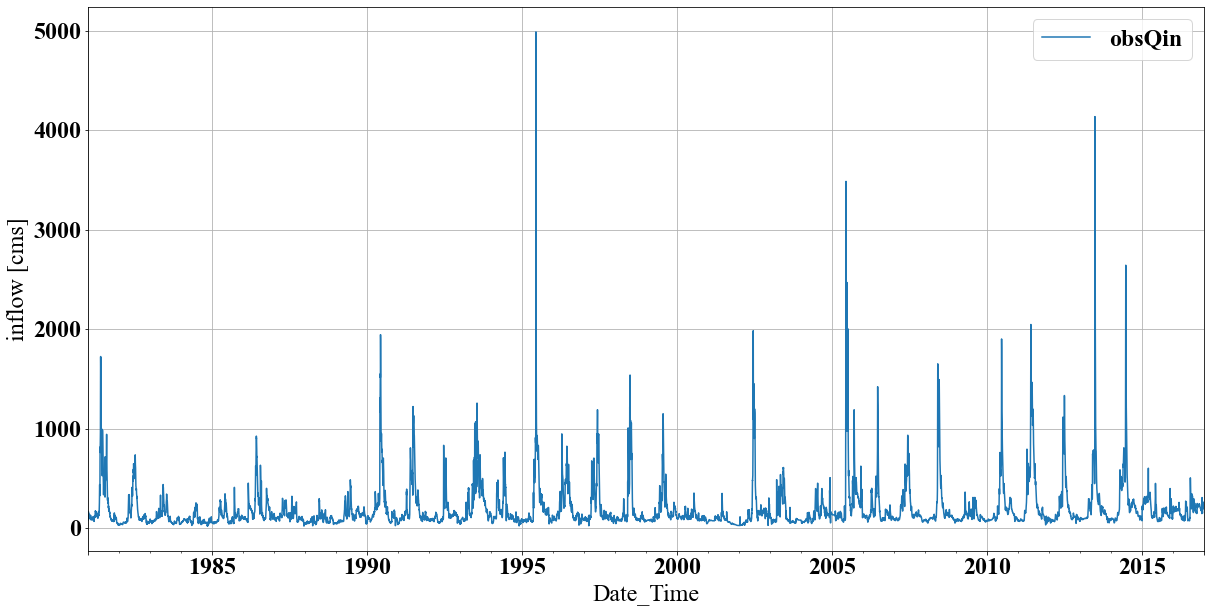

In [40]:
# load the forcings
obs = pd.read_csv('../data/'+str(lake_ID)+'_obs.csv') # read input
obs ['Date_Time'] = pd.to_datetime(obs ['Date'])
obs ['year'] = obs.Date_Time.dt.year
obs ['month'] = obs.Date_Time.dt.month
obs ['day'] = obs.Date_Time.dt.day
obs ['day_of_year'] = obs.Date_Time.dt.day_of_year
obs = obs.set_index('Date_Time')
print(obs) # print

plt.figure(figsize=(20,10))
obs.obsQin.plot() # plot
plt.legend()
plt.grid()
plt.ylabel('inflow [cms]')


In [41]:
# load the parameters
param = pd.read_csv('../data/param.csv')
param = param [param['SUBID']==lake_ID] # subset to the lake id
param = param.reset_index(drop=True) # reindex and drop index colomn 
print(param) # print


     SUBID      ASURF     WREF     WLIM     WMIN     QAVG   QAMP  QPHA   QEXP  \
0  1001209  458000000  556.706  550.664  549.582  200.231  0.449    61  0.086   

      QRAT    QMIN    QMAX    MAIN  BMAX  DEST  BFLAG  
0  403.254 -9999.0 -9999.0 -9999.0 -9999 -9999      1  


In [47]:
# parameters set to default values
Par_level_emgspl = param.WREF.item()  # parameter emergency spillway height
Par_level_lim    = param.WLIM.item()  # parameter normal operation height
Par_level_min    = param.WMIN.item()  # minimum operating height
#Par_level_zero   = Par_level_min - 1  # we need an arbitrary minimum storage values for the storage
Par_Qrate_emgspl = param.QRAT.item()  # 
Par_Pexp_emgspl  = param.QEXP.item()  # 
Par_Qavg_mainspl = param.QAVG.item()  # 
Par_Qamp_mainspl = param.QAMP.item()  # 
Par_phs_mainspl  = param.QPHA.item()  # 
Par_F_managed    = param.BFLAG.item() # 
Par_Area_avg     = param.ASURF.item() #  

print(Par_level_emgspl, Par_level_lim, Par_level_min, Par_Qrate_emgspl, Par_Pexp_emgspl, Par_Qavg_mainspl,\
      Par_Qamp_mainspl, Par_phs_mainspl, Par_F_managed, Par_Area_avg)


556.706 550.664 549.582 403.254 0.086 200.231 0.449 61 1 458000000


In [48]:
# parameterization for one time step

def HYPE_lake (# Inputs
              S, #storage at the current time step
              up_stream, # upstream inflow at the current time step
              # HYPE paraemters for one outlet
              Par_level_emgspl, # parameter emergency spillway height
              Par_level_lim,    # parameter normal operation height
              Par_level_min,    # minimum operating height
              #Par_level_zero,   # 
              Par_Qrate_emgspl, # 
              Par_Pexp_emgspl,  # 
              Par_Qavg_mainspl, #
              Par_Qamp_mainspl, #
              Par_phs_mainspl,  #
              Par_F_managed,    #
              Par_Area_avg,     # 
              # simulation paraemters
              yyyy,    # current simulation year 
              mm,      # current simulation month
              dd,      # current simulation day
              hh,      # current simulation hour
              mi,      # current simulation minute
              ss,      # current simulation second
              day_of_year,
              dt):      # time steps of simulation)
    
    # update the S
    S = S + up_stream * dt
    
    # trasfer the S to height using the average A
    H_t = S/Par_Area_avg+Par_level_min# Par_level_zero
    
    # calculate the Fsin
    Fsin = np.maximum(0, 1+Par_Qamp_mainspl*np.sin(2*np.pi*((day_of_year+Par_phs_mainspl)/365)))
    
    # calculate the Flin
    Flin = np.minimum (np.maximum((H_t-Par_level_min)/(Par_level_lim-Par_level_min),0),1)
    
    # calculate the Fmanaged
    Fmanaged = Par_F_managed
    
    # calculate Qmain
    Qmain = Par_Qavg_mainspl * Fsin * Flin * Fmanaged
    
    # calculate Qspillwat
    if H_t > Par_level_emgspl:
        Qspill = Par_Qrate_emgspl * (H_t-Par_level_emgspl)**Par_Pexp_emgspl
    else:
        Qspill = 0
    
    # assign the Q; outflow based on Qmain an Qspillwat
    Q = np.maximum (Qspill, Qmain)
    
    # check that the Q is not more than the available storage
    Q = np.minimum (Q, np.maximum(0,(H_t-Par_level_min)*Par_Area_avg/dt))
    
    # update the storage
    S = S - Q * dt
    
    # return S, outflow, and water level
    return S, Q, H_t
    

In [49]:

counter = 0 # model counter
# 
S_time_series = np.zeros(len(obs))
Q_time_series = np.zeros(len(obs))
H_time_series = np.zeros(len(obs))


for date in obs.index: # loop over the time period
    
    yyyy = date.year
    mm = date.month
    dd = date.day
    hh = date.hour
    mi = date.minute
    ss = date.second
    day_of_year = date.day_of_year
    
    if counter == 0:
        S = 10000
    up_stream = obs.iloc[obs.index == date]['obsQin'].item()
    
    S, Q, H = HYPE_lake (# Inputs
                      S, #storage at the current time step
                      up_stream, # upstream inflow at the current time step
                      # HYPE paraemters for one outlet
                      Par_level_emgspl, # parameter emergency spillway height
                      Par_level_lim,    # parameter normal operation height
                      Par_level_min,    # minimum operating height
                      #Par_level_zero,   #
                      Par_Qrate_emgspl, # 
                      Par_Pexp_emgspl,  # 
                      Par_Qavg_mainspl, #
                      Par_Qamp_mainspl, #
                      Par_phs_mainspl,  #
                      Par_F_managed,    #
                      Par_Area_avg,     # 
                      # simulation paraemters
                      yyyy,    # current simulation year 
                      mm,      # current simulation month
                      dd,      # current simulation day
                      hh,      # current simulation hour
                      mi,      # current simulation minute
                      ss,      # current simulation second
                      day_of_year, # day of the year from 1 of january
                      86400)      # time steps of simulation)
    
    S_time_series [counter] = S
    Q_time_series [counter] = Q
    H_time_series [counter] = H
    
    
    counter = counter + 1


                i        Date  simWSL_Py  simQmn_Py  simQbr_Py
Date_Time                                                     
1981-01-01      0  1981-01-01    556.706    278.977          0
1981-01-02      1  1981-01-02    556.669    279.712          0
1981-01-03      2  1981-01-03    556.638    280.423          0
1981-01-04      3  1981-01-04    556.611    281.111          0
1981-01-05      4  1981-01-05    556.590    281.775          0
...           ...         ...        ...        ...        ...
2016-12-27  13144  2016-12-27    552.829    275.806          0
2016-12-28  13145  2016-12-28    552.826    276.633          0
2016-12-29  13146  2016-12-29    552.824    277.437          0
2016-12-30  13147  2016-12-30    552.820    278.219          0
2016-12-31  13148  2016-12-31    552.815    278.977          0

[13149 rows x 5 columns]


Text(0, 0.5, 'outflow [cms]')

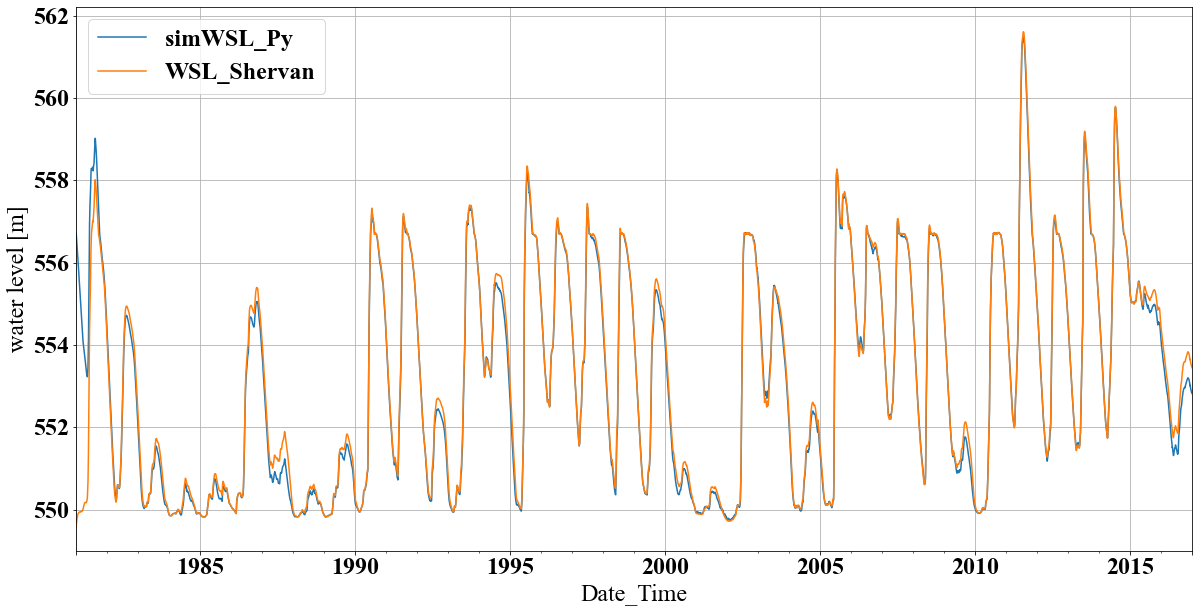

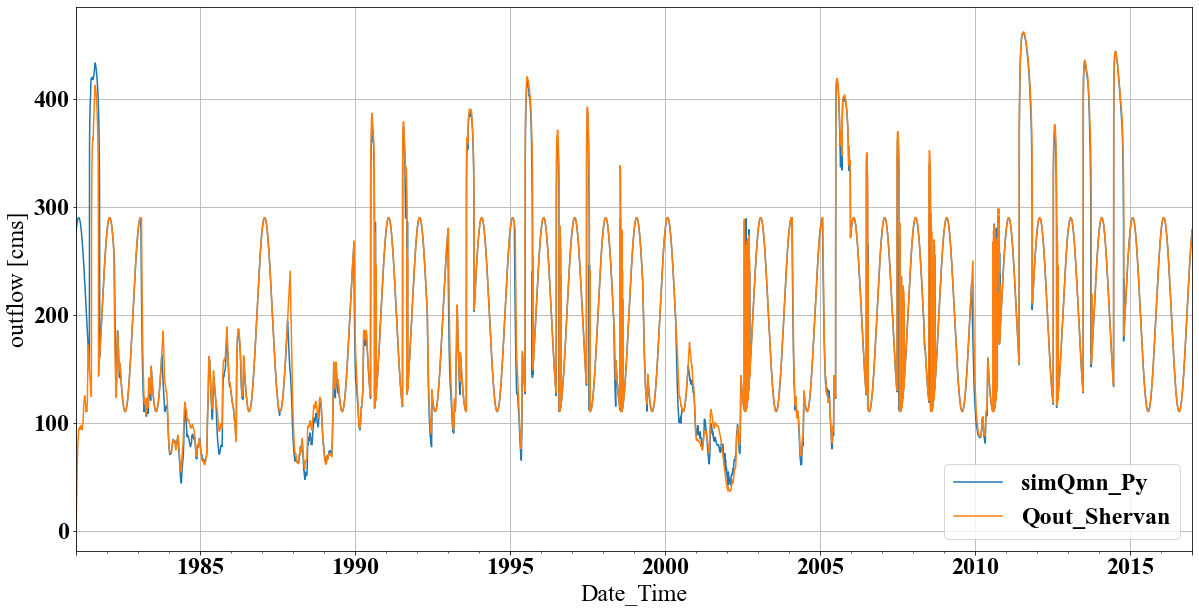

In [50]:
# load the forcings
sim = pd.read_csv('../data/'+str(lake_ID)+'_sim.csv') # read input
sim ['Date_Time'] = pd.to_datetime(sim ['Date'])
sim = sim.set_index('Date_Time')
print(sim) # print
sim['WSL_Shervan'] = H_time_series
sim['Qout_Shervan'] = Q_time_series
# plot water level
plt.figure(figsize=(20,10))
sim.simWSL_Py.plot() # plot
sim.WSL_Shervan.plot() # plot
plt.legend()
plt.grid()
plt.ylabel('water level [m]')
# plot storage with the populated
plt.figure(figsize=(20,10))
sim.simQmn_Py.plot() # plot
sim.Qout_Shervan.plot() # plot
plt.legend()
plt.grid()
plt.ylabel('outflow [cms]')

